In [19]:
%matplotlib inline

In [20]:
import firedrake

In [21]:
# from adapt_utils.unsteady.swe.tsunami import dtopotools
from clawpack.geoclaw import dtopotools

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as si
import urllib.request

In [23]:
from adapt_utils.case_studies.tohoku.options.options import TohokuOptions
from adapt_utils.unsteady.swe.tsunami.conversion import utm_to_lonlat
from adapt_utils.unsteady.swe.tsunami.solver import AdaptiveTsunamiProblem

In [24]:
def use_degrees(axes, x=True, y=True):
    if x:
        xlim = axes.get_xlim()
        axes.set_xticks(axes.get_xticks())
        axes.set_xticklabels([r"${:.0f}^\circ$".format(tick) for tick in axes.get_xticks()])
        axes.set_xlim(xlim)
    if y:
        ylim = axes.get_ylim()
        axes.set_yticks(axes.get_yticks())
        axes.set_yticklabels([r"${:.0f}^\circ$".format(tick) for tick in axes.get_yticks()])
        axes.set_ylim(ylim)

In this notebook we generate a source using an array of Okada functions, each of which corresponds to a subfault.
In the work of [1] a 19 x 10 array is used.
We shall collect data on-the-fly from [this webpage](http://ji.faculty.geol.ucsb.edu/big_earthquakes/2011/03/0311_v3/result_c/static_out).
The collected data includes latitudes, longitudes and depths of each subfault, as well as strike, slip, dip and rake parameter values.
Each Okada function has length 25km and width 20km.
Note that the data also includes initial times, as well as rise and end times for each subfault, although we do not use those here.

An alternative approach is to use the GCMT parameters for earthquake found at the [Global Centroid Moment Tensor Project database](http://www.globalcmt.org/CMTsearch.html).

[1] _Focal mechanism and slip history of the 2011 Mw 9.1 off the Pacific coast of Tohoku Earthquake, constrained with teleseismic body and surface waves_ (2012), Shao et al.

In [25]:
url = "http://ji.faculty.geol.ucsb.edu/big_earthquakes/2011/03/0311_v3/result_c/static_out"
with urllib.request.urlopen(url) as fp:
    data_bytes = fp.read()                # read webpage as bytes
    data_str = data_bytes.decode("utf8")  # convert to a string

In [26]:
controls = ('latitude', 'longitude', 'depth', 'slip', 'rake', 'strike', 'dip')
source_parameters = {}
for control in controls:
    source_parameters[control] = []
source_parameters['length'] = []
source_parameters['width'] = []

i = 0
for line in data_str.split('\n'):
    i += 1
    if i <= 12:
        continue
    for word, control in zip(line.split(), controls):
        val = float(word)
        if control == 'slip':
            val /= 100  # convert from cm to m
        if control == 'depth':
            val *= 1000  # convert from km to m
        source_parameters[control].append(val)
    if line not in ('', '\n'):
        source_parameters['length'].append(25.0e+03)
        source_parameters['width'].append(20.0e+03)

In [27]:
mean_source_parameters = {  # source is based on a 19x10 grid
    'length': 19*source_parameters['length'][0],
    'width': 10*source_parameters['width'][0],
}
for control in controls:
    mean_source_parameters[control] = np.mean(source_parameters[control])
    print("mean {:10s}:  {:.2f}".format(control, mean_source_parameters[control]))
print("total length   :  {:.2f}".format(mean_source_parameters['length']))
print("total width    :  {:.2f}".format(mean_source_parameters['width']))

mean latitude  :  37.91
mean longitude :  142.66
mean depth     :  24736.48
mean slip      :  12.54
mean rake      :  67.18
mean strike    :  198.00
mean dip       :  10.00
total length   :  475000.00
total width    :  200000.00


Function to create a fault from Okada control parameters GeoCLAW's `Fault` and `Subfault` classes.

In [28]:
def set_fault(source_parameters, coordinate_specification="centroid", verbose=True):
    """
    Create a fault from a list of subfault parameters.
    
    :kwarg coordinate_specification: choose from 'top center', 'bottom center', 'centroid', 'noaa sift' and
        'top upstrike'.
    :kwarg verbose: toggle printing of statistics.
    :return: a Geoclaw :class:`Fault` object comprised of :class:`Subfault`s constructed from the inputs.
    """
    num_subfaults = len(source_parameters['latitude'])
    for var in source_parameters:
        assert len(source_parameters[var]) == num_subfaults
    
    # Create subfaults
    subfaults = [dtopotools.SubFault() for i in range(num_subfaults)]
    msg = "subfault {:d}: shear modulus {:4.1e} Pa, seismic moment is {:4.1e}"
    for i in range(num_subfaults):
        for var in source_parameters:
            subfaults[i].__setattr__(var, source_parameters[var][i])
        subfaults[i].coordinate_specification = coordinate_specification
        if verbose:
            print(msg.format(i, subfaults[i].mu, subfaults[i].Mo()))
        
    # Create fault
    fault = dtopotools.Fault(subfaults=subfaults)
    if verbose:
        print("this corresponds to an earthquake with moment magnitude {:4.1e}".format(fault.Mw()))
        
    return fault

In [29]:
fault = set_fault(source_parameters, coordinate_specification='centroid')

subfault 0: shear modulus 4.0e+10 Pa, seismic moment is 2.1e+17
subfault 1: shear modulus 4.0e+10 Pa, seismic moment is 6.4e+19
subfault 2: shear modulus 4.0e+10 Pa, seismic moment is 1.2e+20
subfault 3: shear modulus 4.0e+10 Pa, seismic moment is 2.5e+20
subfault 4: shear modulus 4.0e+10 Pa, seismic moment is 4.0e+20
subfault 5: shear modulus 4.0e+10 Pa, seismic moment is 5.5e+20
subfault 6: shear modulus 4.0e+10 Pa, seismic moment is 6.6e+20
subfault 7: shear modulus 4.0e+10 Pa, seismic moment is 6.9e+20
subfault 8: shear modulus 4.0e+10 Pa, seismic moment is 7.0e+20
subfault 9: shear modulus 4.0e+10 Pa, seismic moment is 6.9e+20
subfault 10: shear modulus 4.0e+10 Pa, seismic moment is 6.3e+20
subfault 11: shear modulus 4.0e+10 Pa, seismic moment is 4.9e+20
subfault 12: shear modulus 4.0e+10 Pa, seismic moment is 3.4e+20
subfault 13: shear modulus 4.0e+10 Pa, seismic moment is 2.2e+20
subfault 14: shear modulus 4.0e+10 Pa, seismic moment is 1.3e+20
subfault 15: shear modulus 4.0e+10 

In [30]:
x = np.linspace(138, 148, 201)
y = np.linspace(32., 42, 201)
times = [1.0]

In [31]:
fault.create_dtopography(x, y, times)
dtopo = fault.dtopo

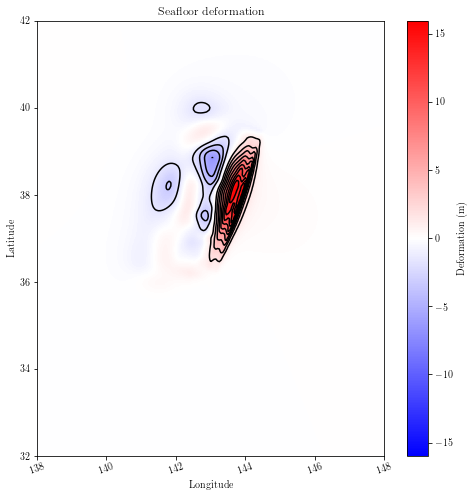

In [32]:
fig, axes = plt.subplots(figsize=(8, 8))
dtopo.plot_dZ_colors(t=1.0, axes=axes);
axes.set_xlabel('Longitude');
axes.set_ylabel('Latitude');

In [33]:
op = TohokuOptions(level=2)
op.get_lonlat_mesh()

Interpolate the deformation into a $\mathbb P1$ space

In [34]:
surf_interp = si.interp2d(x, y, fault.dtopo.dZ)

In [35]:
P1 = firedrake.FunctionSpace(op.lonlat_mesh, "CG", 1)
surf = firedrake.Function(P1)
for i, xy in enumerate(op.lonlat_mesh.coordinates.dat.data):
    surf.dat.data[i] = surf_interp(*xy)

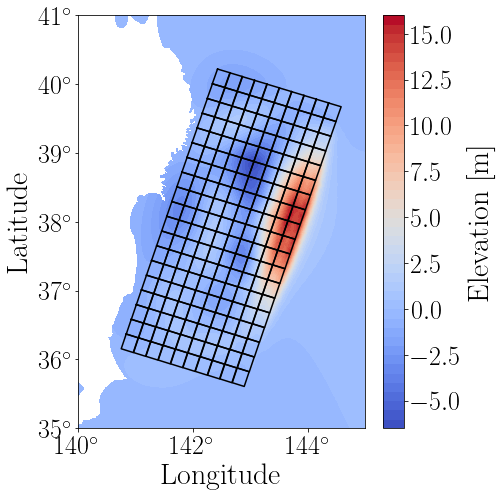

In [39]:
fig, axes = plt.subplots(figsize=(7, 7))

cbar = fig.colorbar(firedrake.tricontourf(surf, cmap='coolwarm', axes=axes, levels=50), ax=axes);
cbar.set_label(r"Elevation [$\mathrm m$]", fontsize=30)
cbar.ax.tick_params(labelsize=26);
# fault.plot_subfaults(axes=axes);
for subfault in fault.subfaults:
    x_corners = [subfault.corners[2][0],
                 subfault.corners[3][0],
                 subfault.corners[0][0],
                 subfault.corners[1][0],
                 subfault.corners[2][0]]
    y_corners = [subfault.corners[2][1],
                 subfault.corners[3][1],
                 subfault.corners[0][1],
                 subfault.corners[1][1],
                 subfault.corners[2][1]]
    axes.plot(x_corners, y_corners, 'k-')
axes.set_xlim([140, 145]);
axes.set_ylim([35, 41]);
axes.set_xticks([140, 142, 144])
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(26);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(26);
use_degrees(axes)
axes.set_xlabel('Longitude', fontsize=30);
axes.set_ylabel('Latitude', fontsize=30);
plt.tight_layout()
plt.savefig("plots/19x10_subfault_array.pdf")
plt.savefig("plots/19x10_subfault_array.png")

For simulations we need the displacement in UTM coordinates

In [18]:
op.family = 'dg-cg'
op.save_timeseries = True

swp = AdaptiveTsunamiProblem(op)
surf = firedrake.Function(swp.P1[0])
for i, xy in enumerate(op.lonlat_mesh.coordinates.dat.data):
    surf.dat.data[i] = surf_interp(*xy)
u, eta = swp.fwd_solutions[0].split()
eta.interpolate(surf);

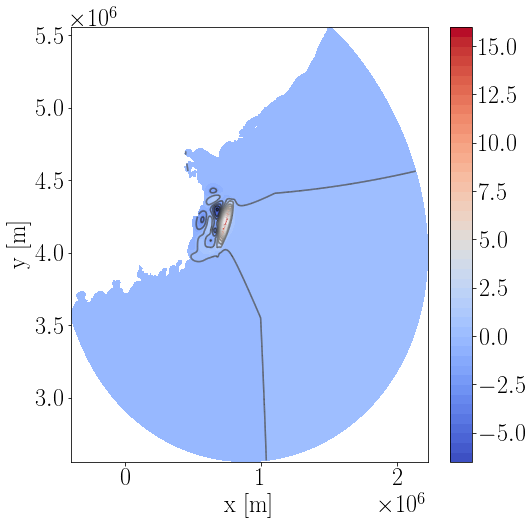

In [19]:
fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(firedrake.tricontourf(surf, cmap='coolwarm', axes=axes, levels=50), ax=axes);
firedrake.tricontour(surf, cmap='gray', axes=axes, levels=20);
axes.set_xlabel('x [m]');
axes.set_ylabel('y [m]');

Let's run a simulation with this initial surface and see what the gauge timeseries look like.

In [21]:
swp.setup_solver_forward_step(0)
swp.solve_forward_step(0)

FORWARD SOLVE  time     0.00  (  0.00) seconds
    elevation norm           at time    0.0 =  1.2367e+06
    velocity norm            at time    0.0 =  0.0000e+00
    quantity of interest     at time    0.0 =  0.0000e+00
    quantity of interest     at time   15.0 =  0.0000e+00
    quantity of interest     at time   30.0 =  0.0000e+00
    quantity of interest     at time   45.0 =  0.0000e+00
FORWARD SOLVE  time    60.00  ( 79.21) seconds
    elevation norm           at time   60.0 =  1.1002e+06
    velocity norm            at time   60.0 =  2.5975e+04
    quantity of interest     at time   60.0 =  0.0000e+00
    quantity of interest     at time   75.0 =  0.0000e+00
    quantity of interest     at time   90.0 =  0.0000e+00
    quantity of interest     at time  105.0 =  0.0000e+00
FORWARD SOLVE  time   120.00  ( 40.49) seconds
    elevation norm           at time  120.0 =  9.0062e+05
    velocity norm            at time  120.0 =  4.2182e+04
    quantity of interest     at time  120.0 =  

    quantity of interest     at time 1215.0 =  0.0000e+00
    quantity of interest     at time 1230.0 =  0.0000e+00
    quantity of interest     at time 1245.0 =  0.0000e+00
FORWARD SOLVE  time  1260.00  ( 42.45) seconds
    elevation norm           at time 1260.0 =  8.6986e+05
    velocity norm            at time 1260.0 =  1.0870e+05
    quantity of interest     at time 1260.0 =  0.0000e+00
    quantity of interest     at time 1275.0 =  0.0000e+00
    quantity of interest     at time 1290.0 =  0.0000e+00
    quantity of interest     at time 1305.0 =  0.0000e+00
FORWARD SOLVE  time  1320.00  ( 40.92) seconds
    elevation norm           at time 1320.0 =  8.6813e+05
    velocity norm            at time 1320.0 =  1.1567e+05
    quantity of interest     at time 1320.0 =  0.0000e+00
    quantity of interest     at time 1335.0 =  0.0000e+00
    quantity of interest     at time 1350.0 =  0.0000e+00
    quantity of interest     at time 1365.0 =  0.0000e+00
FORWARD SOLVE  time  1380.00  ( 40.6

    quantity of interest     at time 2460.0 =  0.0000e+00
    quantity of interest     at time 2475.0 =  0.0000e+00
    quantity of interest     at time 2490.0 =  0.0000e+00
    quantity of interest     at time 2505.0 =  0.0000e+00
FORWARD SOLVE  time  2520.00  ( 41.81) seconds
    elevation norm           at time 2520.0 =  8.7229e+05
    velocity norm            at time 2520.0 =  2.5751e+05
    quantity of interest     at time 2520.0 =  0.0000e+00
    quantity of interest     at time 2535.0 =  0.0000e+00
    quantity of interest     at time 2550.0 =  0.0000e+00
    quantity of interest     at time 2565.0 =  0.0000e+00
FORWARD SOLVE  time  2580.00  ( 40.80) seconds
    elevation norm           at time 2580.0 =  8.8362e+05
    velocity norm            at time 2580.0 =  2.5110e+05
    quantity of interest     at time 2580.0 =  0.0000e+00
    quantity of interest     at time 2595.0 =  0.0000e+00
    quantity of interest     at time 2610.0 =  0.0000e+00
    quantity of interest     at time

    velocity norm            at time 3720.0 =  2.8703e+05
    quantity of interest     at time 3720.0 =  0.0000e+00
    quantity of interest     at time 3735.0 =  0.0000e+00
    quantity of interest     at time 3750.0 =  0.0000e+00
    quantity of interest     at time 3765.0 =  0.0000e+00
FORWARD SOLVE  time  3780.00  ( 40.46) seconds
    elevation norm           at time 3780.0 =  8.6251e+05
    velocity norm            at time 3780.0 =  2.8049e+05
    quantity of interest     at time 3780.0 =  0.0000e+00
    quantity of interest     at time 3795.0 =  0.0000e+00
    quantity of interest     at time 3810.0 =  0.0000e+00
    quantity of interest     at time 3825.0 =  0.0000e+00
FORWARD SOLVE  time  3840.00  ( 38.70) seconds
    elevation norm           at time 3840.0 =  8.7554e+05
    velocity norm            at time 3840.0 =  2.7071e+05
    quantity of interest     at time 3840.0 =  0.0000e+00
    quantity of interest     at time 3855.0 =  0.0000e+00
    quantity of interest     at time

    elevation norm           at time 4980.0 =  8.8267e+05
    velocity norm            at time 4980.0 =  2.6029e+05
    quantity of interest     at time 4980.0 =  0.0000e+00
    quantity of interest     at time 4995.0 =  0.0000e+00
    quantity of interest     at time 5010.0 =  0.0000e+00
    quantity of interest     at time 5025.0 =  0.0000e+00
FORWARD SOLVE  time  5040.00  ( 40.77) seconds
    elevation norm           at time 5040.0 =  8.7570e+05
    velocity norm            at time 5040.0 =  2.6391e+05
    quantity of interest     at time 5040.0 =  0.0000e+00
    quantity of interest     at time 5055.0 =  0.0000e+00
    quantity of interest     at time 5070.0 =  0.0000e+00
    quantity of interest     at time 5085.0 =  0.0000e+00
FORWARD SOLVE  time  5100.00  ( 40.39) seconds
    elevation norm           at time 5100.0 =  8.7155e+05
    velocity norm            at time 5100.0 =  2.6512e+05
    quantity of interest     at time 5100.0 =  0.0000e+00
    quantity of interest     at time

FORWARD SOLVE  time  6240.00  ( 40.90) seconds
    elevation norm           at time 6240.0 =  8.3950e+05
    velocity norm            at time 6240.0 =  2.4422e+05
    quantity of interest     at time 6240.0 =  0.0000e+00
    quantity of interest     at time 6255.0 =  0.0000e+00
    quantity of interest     at time 6270.0 =  0.0000e+00
    quantity of interest     at time 6285.0 =  0.0000e+00
FORWARD SOLVE  time  6300.00  ( 40.47) seconds
    elevation norm           at time 6300.0 =  8.4404e+05
    velocity norm            at time 6300.0 =  2.3994e+05
    quantity of interest     at time 6300.0 =  0.0000e+00
    quantity of interest     at time 6315.0 =  0.0000e+00
    quantity of interest     at time 6330.0 =  0.0000e+00
    quantity of interest     at time 6345.0 =  0.0000e+00
FORWARD SOLVE  time  6360.00  ( 40.94) seconds
    elevation norm           at time 6360.0 =  8.4597e+05
    velocity norm            at time 6360.0 =  2.3403e+05
    quantity of interest     at time 6360.0 =  

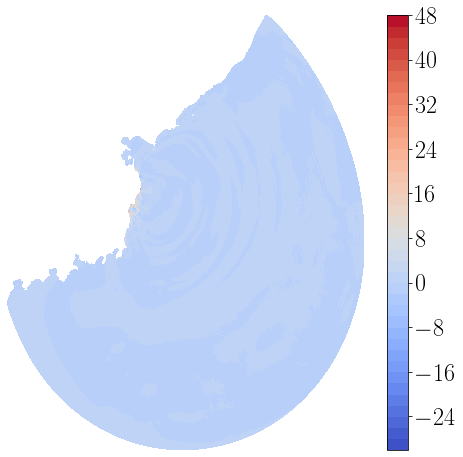

In [22]:
fig, axes = plt.subplots(figsize=(8, 8))
fig.colorbar(firedrake.tricontourf(eta, cmap='coolwarm', levels=50, axes=axes), ax=axes);
axes.axis(False);

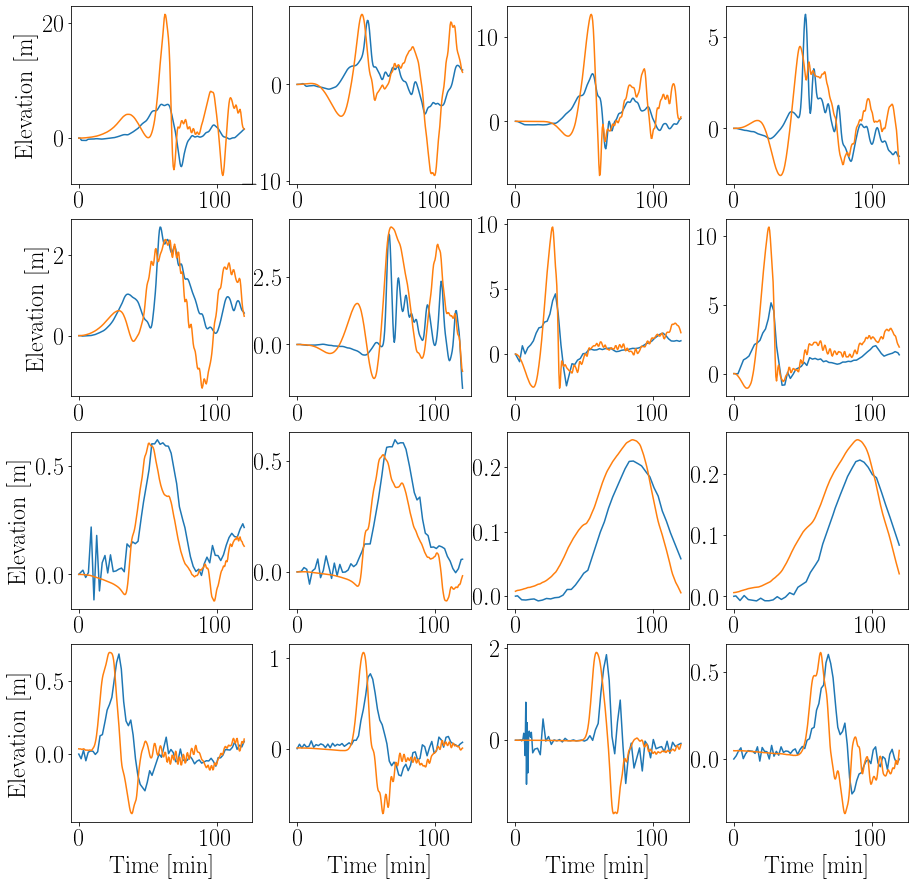

In [28]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15, 15))

for i, gauge in enumerate(op.gauges):
    ax = axes[i // 4, i % 4]
    times = np.linspace(0, op.end_time/60, len(op.gauges[gauge]['data']))
    ax.plot(times, op.gauges[gauge]['data'], label='Data')
    ax.plot(times, op.gauges[gauge]['timeseries'], label='Simulated')
    if i // 4 == 3:
        ax.set_xlabel('Time [min]')
    if i % 4 == 0:
        ax.set_ylabel('Elevation [m]')
#     ax.legend()

The fit isn't actually that bad, although the elevation is far too large for some gauges.
This is likely because we have assumed that all 190 subfaults trigger at the same instant.